In [341]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read, write
from ase import Atoms
from pymatgen.io.vasp.outputs import BSVasprun
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.io.vasp.outputs import Procar
from pymatgen.electronic_structure.bandstructure import Spin
from copy import deepcopy
from tqdm import tqdm
from IPython.display import Image
from typing import Tuple, List

In [306]:
class Atoms_plot(Atoms):
     """
    A derived class from ASE Atoms that adds methods for generating plots (mainly the top view plot for 2D materials)
    and replicating the structure.

    This class extends the functionality of the ASE Atoms class by providing a method to plot the top view of the 
    atomic structure, including atom positions and chemical bonds. It also includes a method to replicate the 
    atomic structure based on a given replicate vector.
    """
    
    def __init__(self, symbols=None,
                 positions=None, numbers=None,
                 tags=None, momenta=None, masses=None,
                 magmoms=None, charges=None,
                 scaled_positions=None,
                 cell=None, pbc=None, celldisp=None,
                 constraint=None,
                 calculator=None,
                 info=None,
                 velocities=None):
        
        """
        Initializes the Atoms_plot object with the given parameters, inheriting from the ASE Atoms class.

        :param symbols: Atomic symbols, one of the many possible ways to specify the atoms in the Atoms object.
        :type symbols: str or list
        :param positions: Atomic positions.
        :type positions: list or ndarray
        :param numbers: Atomic numbers.
        :type numbers: list or ndarray
        :param tags: Tags for the atoms.
        :type tags: list or ndarray
        :param momenta: Momenta for the atoms.
        :type momenta: list or ndarray
        :param masses: Masses for the atoms.
        :type masses: list or ndarray
        :param magmoms: Magnetic moments for the atoms.
        :type magmoms: list or ndarray
        :param charges: Charges for the atoms.
        :type charges: list or ndarray
        :param scaled_positions: Scaled positions for the atoms.
        :type scaled_positions: list or ndarray
        :param cell: Unit cell of the system.
        :type cell: list or ndarray
        :param pbc: Periodic boundary conditions flags.
        :type pbc: list or ndarray
        :param celldisp: Displacement of the cell.
        :type celldisp: list or ndarray
        :param constraint: Constraints for the atoms.
        :type constraint: list or ASE constraint object
        :param calculator: Calculator for the atoms.
        :type calculator: ASE calculator object
        :param info: Additional information for the atoms.
        :type info: dict
        :param velocities: Velocities for the atoms.
        :type velocities: list or ndarray
        """
        
        super().__init__(symbols, positions, numbers, tags, momenta, masses,
                         magmoms, charges, scaled_positions, cell, pbc, celldisp,
                         constraint, calculator, info, velocities)
        
        
    def replicate_structure(self, replicate_vector: Tuple[int, int, int]) -> 'Atoms_plot':
        """
        Replicates the structure and cell based on the given replicate vector.
        
        :param replicate_vector: A tuple indicating how many times to replicate the structure along each cell vector.
        :type replicate_vector: Tuple[int, int, int]
        
        :returns: A new Atoms_plot object with the replicated structure.
        :rtype: Atoms_plot
        """
        rep_x, rep_y, rep_z = replicate_vector

        # Replicate cell
        new_cell = np.copy(self.get_cell())
        new_cell[0] *= rep_x
        new_cell[1] *= rep_y
        new_cell[2] *= rep_z

        # Replicate positions
        positions = self.get_positions()
        new_positions = []
        new_numbers = []

        for ix in range(rep_x):
            for iy in range(rep_y):
                for iz in range(rep_z):
                    shift = ix * self.get_cell()[0] + iy * self.get_cell()[1] + iz * self.get_cell()[2]
                    for pos in positions:
                        new_positions.append(pos + shift)
                    new_numbers.extend(self.get_atomic_numbers())
        
            
        # Create new Atoms_plot object with replicated data
        new_atoms = Atoms_plot(symbols=None,
                               positions=new_positions,
                               numbers=new_numbers,
                               cell=new_cell,
                               pbc=self.get_pbc()
                               )
        return new_atoms
    
        
    # New method for plot the top view (z/vacuum direction of the 2D material)
    def plot_top_view(self,
                      atom_size: float = 6, 
                      bond_line_width: float = 0.5,
                      box_line_width: float = 0.5,
                      atom_colors: List[str] = None, 
                      up_bond_threshold: float = 2.8, 
                      lo_bond_threshold: float = 1, 
                      save_path = None, 
                      fig_save_name = None, 
                      dpi=600, 
                      show_fig=True) -> None: 
        
        """
        Plots the top view of the supercell from the Z direction, including atom positions and chemical bonds.

        :param atom_size: The size of the atom markers in the plot. Default is 6.
        :type atom_size: float, optional
        :param bond_line_width: The width of the bond lines in the plot. Default is 0.5.
        :type bond_line_width: float, optional
        :param box_line_width: The width of the box lines representing the cell boundaries. Default is 0.5.
        :type box_line_width: float, optional
        :param atom_colors: A list of colors for the atoms. If None, all atoms will be black.
        :type atom_colors: List[str], optional
        :param up_bond_threshold: The maximum distance between two atoms to consider them as bonded. Default is 2.8.
        :type up_bond_threshold: float, optional
        :param lo_bond_threshold: The minimum distance between two atoms to consider them as bonded. Default is 1.
        :type lo_bond_threshold: float, optional
        :param save_path: The directory to save the plot. If None, the current working directory is used.
        :type save_path: str, optional
        :param fig_save_name: The name of the saved plot file. If None, a default name is generated.
        :type fig_save_name: str, optional
        :param dpi: The resolution of the saved plot in dots per inch. Default is 600.
        :type dpi: int, optional
        :param show_fig: Whether to display the plot. Default is True.
        :type show_fig: bool, optional
        """
        
        # Default atom color set to black
        if atom_colors is None:
            atom_colors = ['black'] * len(self.get_positions())

        fig, ax = plt.subplots()

        # Plot supercell
        cell = self.get_cell()
        corners = np.array([[0, 0], cell[0, :2], cell[:2, :2].sum(axis=0), cell[1, :2]])
        corners = np.vstack([corners, corners[0]])  # Close the loop
        ax.plot(corners[:, 0], corners[:, 1], 'k-', linewidth=box_line_width)
        
        # Plot atoms
        for i in range(self.get_global_number_of_atoms()):
            pos = self.get_positions()[i]
            ax.scatter(pos[0], pos[1], s=atom_size, color=atom_colors[i])
        
        # Utility function that check if the atom position is within the supercell
        def in_cell(pos, cell):
            if np.all(pos >= 0) and np.all(pos <= cell.sum(axis=0)):
                return True
            else:
                return False
        
        # Utility function that determine the intersection point of two segments
        def line_intersection(line1, line2):
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

            def det(a, b):
                return a[0] * b[1] - a[1] * b[0]

            div = det(xdiff, ydiff)
            if div == 0:
               raise ValueError('lines do not intersect')

            d = (det(*line1), det(*line2))
            x = det(d, xdiff) / div
            y = det(d, ydiff) / div
            return x, y
        
        # Plot bonds considering periodic boundaries
        ori_pos = self.get_positions()
        xplus1_pos = ori_pos + cell[0]
        xminus1_pos = ori_pos - cell[0]
        yplus1_pos = ori_pos + cell[1]
        yminus1_pos = ori_pos - cell[1]
        
        # Plot for the bonds within the primary cell
        for i in range(len(ori_pos)):
            for j in range(len(ori_pos)):
                distance = np.linalg.norm(ori_pos[i] - ori_pos[j])
                if lo_bond_threshold < distance < up_bond_threshold:
                            ax.plot([ori_pos[i][0], ori_pos[j][0]], [ori_pos[i][1], ori_pos[j][1]], \
                                    'k-', linewidth=bond_line_width)
                        
        # X direction positive side neigboring image
        for i in range(len(ori_pos)):
            for j in range(len(ori_pos)):
                distance = np.linalg.norm(xplus1_pos[i] - ori_pos[j])
                if lo_bond_threshold < distance < up_bond_threshold:
                    try:
                        intersection = line_intersection((xplus1_pos[i][:2], ori_pos[j][:2]), (corners[1], corners[2]))
                        ax.plot([intersection[0], ori_pos[j][0]], [intersection[1], ori_pos[j][1]], 
                                'k-', linewidth=bond_line_width)
                        break
                    except ValueError:
                        continue
                        
        # X direction negative side neigboring image
        for i in range(len(ori_pos)):
            for j in range(len(ori_pos)):
                distance = np.linalg.norm(xminus1_pos[i] - ori_pos[j])
                if lo_bond_threshold < distance < up_bond_threshold:
                    try:
                        intersection = line_intersection((xminus1_pos[i][:2], ori_pos[j][:2]), (corners[3], corners[4]))
                        ax.plot([intersection[0], ori_pos[j][0]], [intersection[1], ori_pos[j][1]], 
                                'k-', linewidth=bond_line_width)
                        break
                    except ValueError:
                        continue
        
        # Y direction positive side neigboring image
        for i in range(len(ori_pos)):
            for j in range(len(ori_pos)):
                distance = np.linalg.norm(yplus1_pos[i] - ori_pos[j])
                if lo_bond_threshold < distance < up_bond_threshold:
                    try:
                        intersection = line_intersection((yplus1_pos[i][:2], ori_pos[j][:2]), (corners[2], corners[3]))
                        ax.plot([intersection[0], ori_pos[j][0]], [intersection[1], ori_pos[j][1]], 
                                'k-', linewidth=bond_line_width)
                        break
                    except ValueError:
                        continue
        
        # Y direction negative side neigboring image
        for i in range(len(ori_pos)):
            for j in range(len(ori_pos)):
                distance = np.linalg.norm(yminus1_pos[i] - ori_pos[j])
                if lo_bond_threshold < distance < up_bond_threshold:
                    try:
                        intersection = line_intersection((yminus1_pos[i][:2], ori_pos[j][:2]), (corners[0], corners[1]))
                        ax.plot([intersection[0], ori_pos[j][0]], [intersection[1], ori_pos[j][1]], 
                                'k-', linewidth=bond_line_width)
                        break
                    except ValueError:
                        continue
        
                                        
        ax.set_axis_off()
        ax.set_aspect('equal')
        if save_path == None:
            save_path = os.getcwd()
        if fig_save_name == None:
            fig_save_name = f'{self.symbols}_top_view.tiff'
        plt.savefig(os.path.join(save_path, fig_save_name), dpi=dpi)
        if show_fig == True:
            plt.show()

In [260]:
a = read(r'/Volumes/sandisk_ssd/work/bluep_gb_official_search_results_validation/bp_1212_literature_potential/6_electronic_structure/CONTCAR')
cell = a.get_cell()
a.symbols

Symbols('P76')

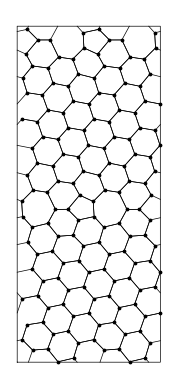

In [308]:
a2 = Atoms_plot()
a2.__dict__.update(a.__dict__)
a2 = a2.replicate_structure((2,1,1))
a2.plot_top_view(up_bond_threshold=2.6, atom_size=3, save_path='/Users/randyzhang/Desktop/', fig_save_name='test.tiff', show_fig=True)

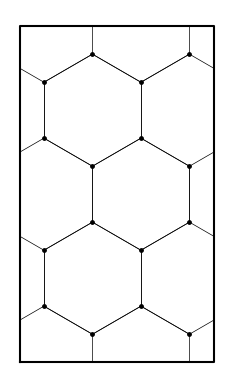

In [299]:
test = read(r'/Users/randyzhang/Documents/work/GA_interface/blue_p', format='vasp')
test2 = Atoms_plot()
test2.__dict__.update(test.__dict__)
#test2.plot_top_view(up_bond_threshold=2.8)
test2_ext = test2.replicate_structure((2, 2, 1))
#test2_ext.write(r'/Users/randyzhang/Desktop/test', format='vasp')
test2_ext.plot_top_view(save_path='/Users/randyzhang/Desktop/', fig_save_name='test.tiff', show_fig=True)

14_electronic_structure:  85%|████████████████████████████████████████████████████████▎         | 29/34 [00:04<00:01,  4.48it/s]/var/folders/pd/8kj8gtc975s1ylbknk3y1x5w0000gn/T/ipykernel_52321/6920946.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.25s/it]


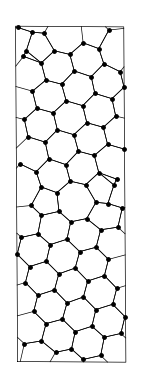

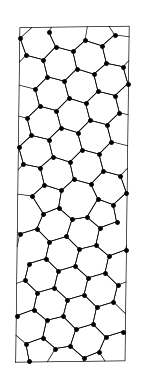

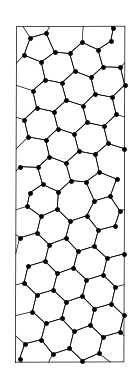

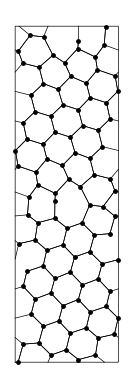

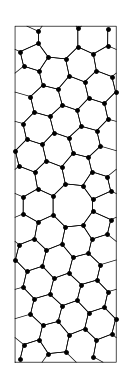

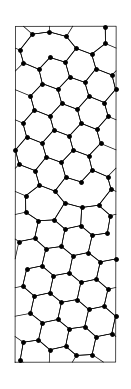

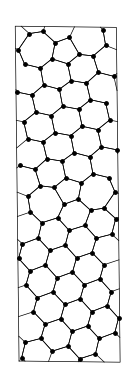

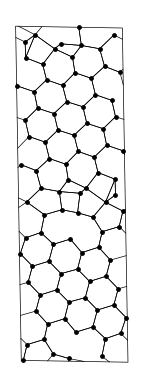

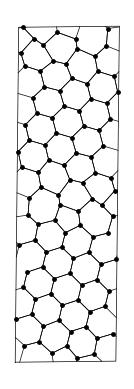

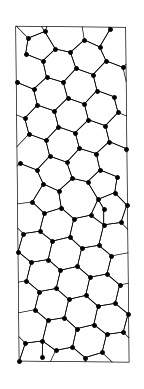

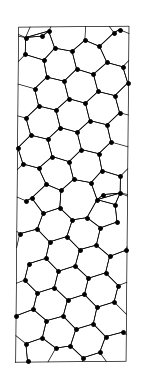

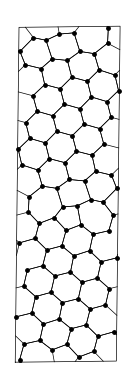

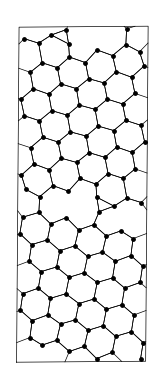

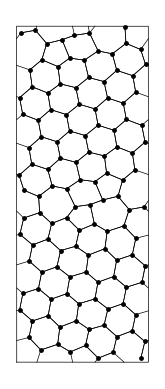

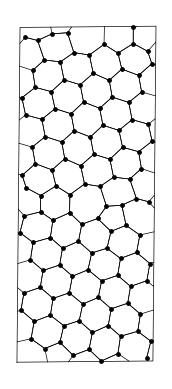

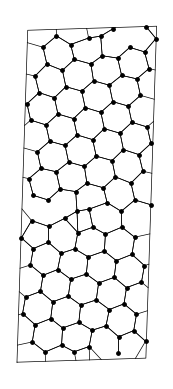

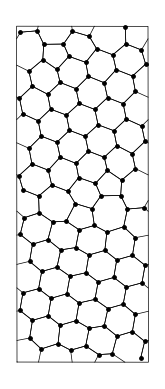

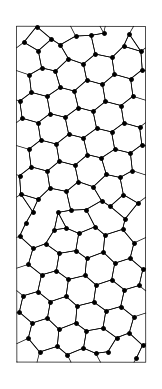

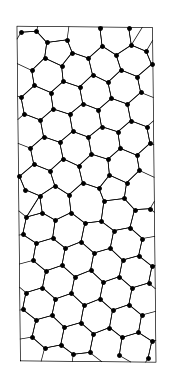

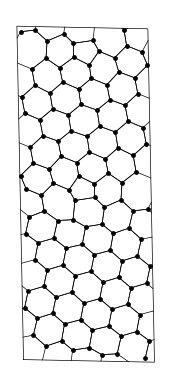

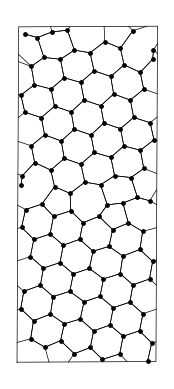

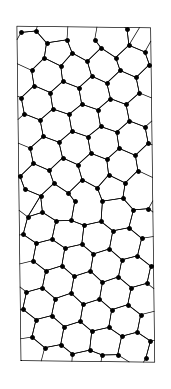

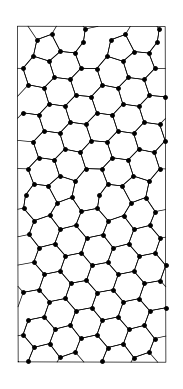

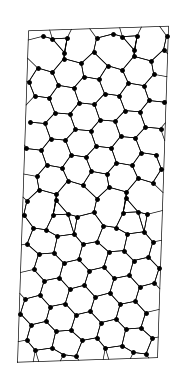

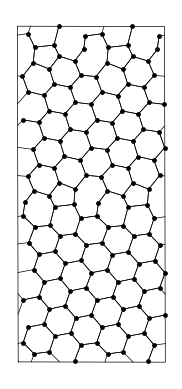

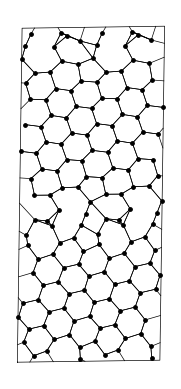

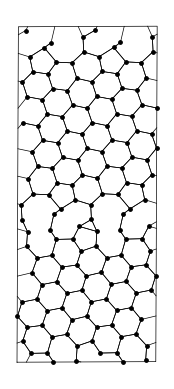

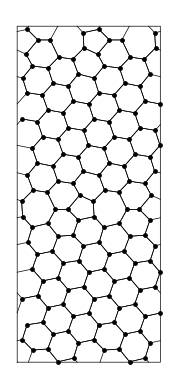

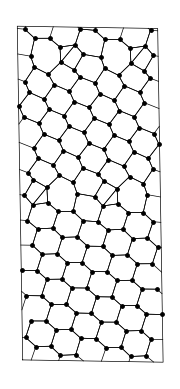

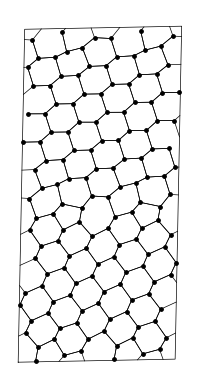

In [332]:
# Generate top view plot for each of the structure

#path = '/Volumes/sandisk_ssd/work/bluep_gb_official_search_results_validation'
path= '/Volumes/sandisk_ssd/work/bluep_gb_official_search_results_validation/test'

# generate a tqdm loop for better demonstration of loop through the folders
folder_loop = tqdm(os.listdir(path))

for folder in folder_loop:
    # check if the folder is the simulaiton folder
    if 'bp' in folder:
        try: 
            int(folder.split('_')[1])
        except ValueError:
            continue
    
        # loop through the folders for each of the orientation of bulk sides
        bulk_folder_path = os.path.join(path, folder)
        bulk_folder_loop = tqdm(os.listdir(bulk_folder_path))
        
        for sim_folder in bulk_folder_loop:
            bulk_folder_loop.set_description(f'{sim_folder}')
            
            if '_electronic_structure' in sim_folder:
                try:
                    contcar_path = os.path.join(path, folder, sim_folder, 'CONTCAR')
                except FileNotFoundError:
                    print(f'Can not read output for: {sim_folder}')
                    continue
                
                # determine the name for each of the structure
                structure_name = folder.split('_')[0] + '_' + folder.split('_')[1]
                if 'literature' in folder:
                    structure_name += '_lp'
                structure_name += '_' + sim_folder.split('_')[0]
                
                # Read the Atoms object and transfer to the Atoms_plot object
                try:
                    atoms_obj = read(contcar_path, format='vasp')
                except FileNotFoundError:
                    continue
                    
                atoms_obj4plot = Atoms_plot()
                atoms_obj4plot.__dict__.update(atoms_obj.__dict__)
                
                # Determine whether to replicate the structure to keep all 
                # the generated structure have approximately same GB length
                longest_gb_len = 20.14 # GB length of (3,4)|(3,4), the longest among all the structures
                gb_len = np.linalg.norm(atoms_obj4plot.get_cell()[0]) # GB length of the current structures
                replicate_vector = (int(longest_gb_len // gb_len), 1, 1)
                
                # Replicate the structure based on the replicate vector
                atoms_obj4plot = atoms_obj4plot.replicate_structure(replicate_vector)
                
                # Plot the top view of the structure
                atoms_obj4plot.plot_top_view(
                      up_bond_threshold = 2.8, 
                      lo_bond_threshold = 1, 
                      save_path = os.path.join(path, folder, sim_folder), 
                      fig_save_name = f'{structure_name}.tiff', 
                      dpi=600, 
                      show_fig=False)